# Bfastmonitor CPU using Python
## This is bfastmonitor Python

In [195]:
import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib
import matplotlib.pyplot as plt

#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import time
import ipywidgets as widgets

from ipyfilechooser import FileChooser
import folium

#specific imports
from functions import set_output_dir, get_size, get_data_dict

In [196]:
%matplotlib inline

## Select a time series folder using ipyfilechooser. The standard download location is in downloads/time_series_name/[0,1,2..n]

### Optional: select a name for your output folder. 

In [48]:
from os.path import expanduser
path = expanduser("~")

def g(directory):
    return(directory)
                          
output_directory_chooser = widgets.interactive(g, 
                        directory=widgets.Text(description="Output storage name:", 
                                               style = {'description_width': 'initial'},
                                               placeholder = "output"))
file_chooser = FileChooser(path)

display(file_chooser)
display(output_directory_chooser)



FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

interactive(children=(Text(value='', description='Output storage name:', placeholder='output', style=Descripti…

In [197]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    set_output_dir(output_directory_chooser)

/home/dven/downloads/Time_series_2020-07-07_11-51-35_Portugal/1/
Defaulting to output directory name "output" 


In [284]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
from numpy import isnan

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import pyopencl

import inspect
        
import time

from datetime import datetime

class Timeseries:
    '''
    
    This is a class that holds a numpy array with time series data, a csv containing dates, and associated geographical metadata.
    
    '''
    
    def __init__(self, time_series_path, dates_path):
        
        self.name = time_series_path + "stack.vrt"
        self.dir = time_series_path
        
        self.time_series = gdal.Open(self.name)
        #time_series = self.time_series
        geotransform = self.time_series.GetGeoTransform()
        
        # geo metadata
        self.xpixelsize = geotransform[1]
        self.ypixelsize = geotransform[5]
        self.latitude = geotransform[3]
        self.longitude = geotransform[0]
        self.ncols = self.time_series.RasterXSize
        self.nrows = self.time_series.RasterYSize
        self.projection = self.time_series.GetProjection()
        self.nbands = self.time_series.RasterCount
        
        band = self.time_series.GetRasterBand(1)
        self.block_size = band.GetBlockSize()
        self.time_dict = {}
        
        # self.raster_stack_orig = time_series.ReadAsArray()
        # This takes really long and will likely cause memory issues when running on large countries, so don't use it
        # Use blocks and base block size on what gdal sets or on ram calculation 
        
        # dates file
        with open(dates_path) as f:
            dates_list = f.read().split('\n')
            self.dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]
        
    def __str__(self):
        return("Timeseries holds {} dates, sized {} by {}.".format(self.nbands,
                                                                        self.ncols,
                                                                        self.nrows))
    def __repr__(self):
            return("Timeseries: {} ".format(self.name))

    def run_bfast(self, block):
        print("start monitor: ", self.start_monitor)
        print("end monitor: ", self.end_monitor)
        print("start history: ", self.start_hist)
        data, dates = crop_data_dates(block, self.dates, self.start_hist, self.end_monitor)
        print("First date: {}".format(dates[0]))
        print("Last date: {}".format(dates[-1]))

        # only apply on a small subset
        #data = data[:,:80,:80]
        
        # change nans to a number bfastmonitor-GPU can work with
        where_are_NaNs = isnan(data)
        data[where_are_NaNs] = -32768

        # fit model
        self.model.fit(data, dates, nan_value = -32768) 
        
        # save breaks and mean magnitudes
        breaks = self.model.breaks # index of date that has a break in dates
        means = self.model.means # magnitudes of breaks
        
        return(breaks,means)
    
    def loop_blocks(self):

        start_time = time.time()
        
        x_block_size = self.block_size[0]
        y_block_size = self.block_size[1]
        print("rastersize: ",self.ncols,self.nrows)
        print("The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize: ",self.block_size)
        print("set blocksize explicitly: ",x_block_size,", " ,y_block_size)
        print("bytes required: ", str(8 * self.ncols * self.nrows * self.nbands))

        first_verstack=True

        # loop over yblocks
        for i in range(0, self.nrows, y_block_size):
            first_horstack = True
            if i + y_block_size < self.nrows:
                rows = y_block_size
            else:
                rows = self.nrows - i

            # Loop over xblocks
            for j in range(0, self.ncols, x_block_size):
                if j + x_block_size < self.ncols:
                    cols = x_block_size
                else:
                    cols = self.ncols - j

                print(j,i,cols,rows)

                # first step creates the array
                if first_horstack==True:
                    data = self.time_series.ReadAsArray(j, i, cols, rows).astype(np.int16)

                    breaks,means = self.run_bfast(data)
                    breaks_array = breaks
                    means_array = means
                    first_horstack=False
                    
                # after that add to array
                else:                    
                    data = self.time_series.ReadAsArray(j, i, cols, rows).astype(np.int16)
                    
                    breaks,means = self.run_bfast(data)
                    breaks_array = np.concatenate((breaks_array,breaks),axis = 1)
                    means_array = np.concatenate((means_array,means),axis = 1)
                    
            # first step create new variable verstack for the data
            if first_verstack == True:
                stack_breaks_array = breaks_array
                stack_means_array = means_array
                first_verstack = False
            
            # after that add data to array
            else:
                stack_breaks_array = np.concatenate((stack_breaks_array,breaks_array),axis=0)
                stack_means_array = np.concatenate((stack_means_array,means_array),axis=0)
                
        self.breaks_array = stack_breaks_array
        self.means_array = stack_means_array
        
        end_time = time.time()
        print("Fitting model over all blocks took {} seconds.".format(end_time - start_time))
        self.time_dict[self.name] = str(end_time - start_time) + " seconds"
        
    def set_bfast_parameters(self, start_monitor, end_monitor, start_hist,freq,k,hfrac,trend,level,backend='opencl',verbose=1,device_id=0):
        self.start_monitor = start_monitor
        self.end_monitor = end_monitor
        self.start_hist = start_hist
        self.freq = freq
        self.k = k
        self.hfrac = hfrac
        self.trend = trend
        self.level = level
        self.backend = backend
        self.verbose = verbose
        
        self.model = BFASTMonitor(
                    self.start_monitor,
                    freq=freq, # add these
                    k=k,
                    hfrac=hfrac,
                    trend=trend,
                    level=level,
                    backend=backend,
                    verbose=verbose,
                    device_id=device_id,
                    )
        
        try:
            print(pyopencl.get_platforms()[0].get_devices())
        except:
            print("You selected  openCL, but no device was found, are you sure you set up a gpu session?")

    
    def get_bfast_parameters(self):
        print("Monitoring starts at: ", self.start_monitor)
        print("Monitoring ends at: ", self.end_monitor)
        print("Dataset history starts at: ", self.start_hist)
        print("frequency: ", self.freq)
        print("harmonic term: ", self.k)
        print("hfrac: ", self.hfrac)
        print("trend: ", self.trend)
        print("level: ", self.level)
        print("GPU opencl or CPU python: ", self.backend)
        print("verbose: ", self.verbose)
        
    
    def log_output_to_txt(self):

        attributes = inspect.getmembers(self, lambda a:not(inspect.isroutine(a)))
        
        logs_directory = "logs"
        if not os.path.exists("logs"):
            os.makedirs(logs_directory)
        
        save_dir = self.dir
        try:
            start_index = save_dir.find("Time_series")
        except:
            start_index = 1
        save_dir = self.dir.replace("/","-")[start_index:] + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + ".txt"
        
        
        with open(str(logs_directory + "/" + save_dir), "w") as f:
            f.write("Date: " + str(datetime.now()))
            f.write("\n")
            for a in attributes:
                if not(a[0].startswith('__') and a[0].endswith('__')):
                    f.write(str(a))
                    f.write("\n")
        
#         print(self.dir)
#         save_dir = self.dir
#         save_dir = self.dir.replace("/","-")
#         print(save_dir)
#         with open(str(save_dir), "w") as f:
#             f.write(self.get_bfast_parameters())
    
    # Don't work anymore, fix later
    def plot_hist(self):
        histlist = []
        for x in range(self.nbands):
            histlist.append(np.isnan(self.raster_stack[x]).sum()/(self.ncols*self.nrows))
        plt.hist(histlist)
        plt.show()
        
    def get_size(self):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(self.dir):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                # skip if it is symbolic link
                if not os.path.islink(fp):
                    total_size += os.path.getsize(fp)
        print(self.dir + "   holds  " + str(total_size) + " bytes")

      

# Load in data: if there are tiles in the directory, create a list and load per tile

In [285]:
# set paths to data
dates_path = os.path.join(timeseries_directory, "dates.csv")
data_list=[]
tile_paths = []

# check for tiles
for file in os.listdir(timeseries_directory):
    if file.startswith('tile'):
        time_series_path =  timeseries_directory + file + "/"
        tile_paths.append(time_series_path)


In [286]:
# # Set up list of time series tiles and their metadata
if not tile_paths:
    print("No tiles, setting up data as one tile")
    ts_data = Timeseries(timeseries_directory, dates_path)
    data_list.append(ts_data)
    
else:
    print("Data consists of tiles, setting up tiles")
    for time_series_path in tile_paths:
        ts_data = Timeseries(time_series_path, dates_path)
        data_list.append(ts_data)
        
# log
# with open("log.txt","a") as file:
#     file.write("Loading in: " + timeseries_directory)
#     file.write(" took {} seconds.".format(end_time - start_time))
#     file.write("\n")

No tiles, setting up data as one tile


### Check some metadata of the created Timeseries class

In [287]:
# data_list = data_list[0:2]
#ts_data = data_list[0]
print("projection: ", data_list[0].projection)
print("pixel size: ", data_list[0].xpixelsize)
ts_data.log_output_to_txt()



projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.0002694945852358568


# Set parameters

In [256]:
# parameters
k = 3
freq = 365
trend = False
hfrac = 0.25
level = 0.05
position = (100,100)

backend = 'opencl'
verbose = 1
device_id = 0


# start_hist = datetime(2018, 1, 1)
# start_monitor = datetime(2019, 1, 1)
# end_monitor = datetime(2020, 1, 1)


# Select monitoring period

In [257]:
dates = ts_data.dates
start_date = dates[10] # 0 or 10 does not work.. 100 did
print("start monitoring period",start_date)
end_date = dates[-1]

def h(y):
    return(y)

pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)


monitoring_period = widgets.interactive(h,
                                     y=widgets.SelectionRangeSlider(
                                            options=options,
                                            index=index,
                                            description='Select the monitoring date range: ',
                                            style = {'description_width': 'initial'},
                                            orientation='horizontal',
                                            layout={'width': '800px',"height":"50px"}))


history_period = widgets.interactive(h, 
                                     y=widgets.SelectionSlider(description="Start history period:", 
                                            options = options,
                                            style = {'description_width': 'initial'}))

display(monitoring_period)
display(history_period)

start monitoring period 2000-03-04 00:00:00


interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 7400), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2000-03-04', Timestamp('…

In [258]:
start_monitor, end_monitor = monitoring_period.result
start_hist = history_period.result

if history_period.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

#start_monitor = datetime(2011, 11, 23)

print("start monitor: ", start_monitor)
print("end monitor: ", end_monitor)
print("start history: ", start_hist)

start monitor:  2000-10-28 00:00:00
end monitor:  2020-06-07 00:00:00
start history:  2000-03-04 00:00:00


### if you have tiles loop over them, or select the first

In [259]:
for ts_data in data_list:
    ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level,backend=backend,verbose=verbose,device_id=device_id)
    ts_data.loop_blocks()
    ts_data.get_bfast_parameters()
    ts_data.log_output_to_txt()
    
# ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level,backend,verbose,device_id)
# print(ts_data.start_monitor)

# ts_data.get_bfast_parameters()

[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x2c403e0>]
rastersize:  14 8
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [14, 8]
set blocksize explicitly:  14 ,  8
bytes required:  473984
0 0 14 8
start monitor:  2000-10-28 00:00:00
end monitor:  2020-06-07 00:00:00
start history:  2000-03-04 00:00:00
First date: 2000-03-28 00:00:00
Last date: 2020-06-07 00:00:00
Processing row 0


AttributeError: 'BFASTMonitorPython' object has no attribute 'first_break'

In [ ]:
for ts_data in  data_list:
    print (ts_data.dir)
    print (ts_data.means_array)

# tile0_0 = data_list[0]
# tile2048_2048 = data_list[1]


# np.concatenate((tile0_0.means_array,tile2048_2048.means_array),axis = 0)
# tile0_0.


## Run bfastmonitor() The loop_blocks code runs over smaller blocks, that may be set based on ram space or user itself..?


# Select negative magnitudes

In [230]:
breaks = ts_data.breaks_array
means = ts_data.means_array

orig_breaks = copy.deepcopy(breaks)
orig_means = copy.deepcopy(means)


In [231]:
# import seaborn as sns

# select only negative magnitudes
no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan

# print("magnitude change heatmap")
# sns.heatmap(orig_means,  linewidths=1)


In [232]:
dates_monitor = []
dates = ts_data.dates
# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


# Classify output for plotting

In [238]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year+1):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 

    breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))
    
    # if we're at the last year
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1 
        continue
    
    # if we're at the first year
    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        continue
    
    # all other years in between
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
    

# Plot output

15


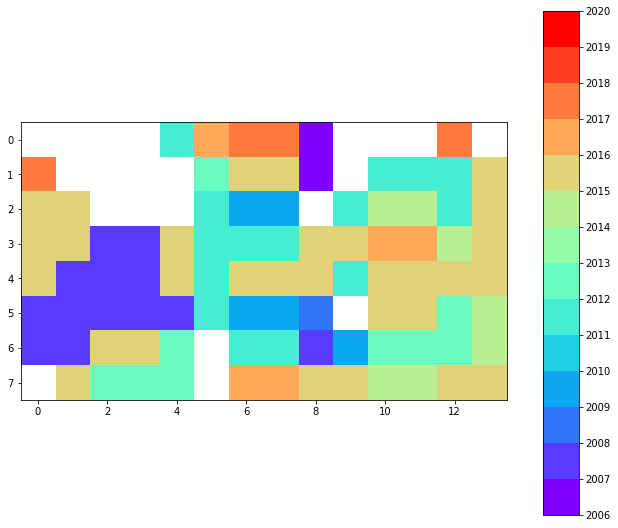

In [239]:
bins = len(idx_starts)


cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

#norm doesn't work with bins = 2 or less... now the colorbar is ugly, fix it later

if bins == 1:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
if bins == 2:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
else:
    im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./output/picture.png")
plt.show()



print(bounds)

In [175]:
print(bounds)

[0. 1.]


In [ ]:
# #this doesn't work yet

# output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',cols, rows, 1 ,gdal.GDT_Float32)  # Open the file

# output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
# srs = osr.SpatialReference()                 # Establish its coordinate encoding
# srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
#                                              # Anyone know how to specify the 
#                                              # IAU2000:49900 Mars encoding?
# output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#                                                    # to the file
# output_raster.GetRasterBand(1).WriteArray(breaks_plot_years)   # Writes my array to the raster

# output_raster.FlushCache()

# output_raster

In [42]:
print(breaks_plot_years)
breaks_plot_years_norm = 1/(breaks_plot_years + 0.01)
print(breaks_plot_years_norm)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [43]:
#cmap = plt.get_cmap("Oranges")

#cmaplist = [cmap(i) for i in range(cmap.N)]

#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# viridis = cm.get_cmap('viridis', 12)
# print(viridis)
# print(viridis(0.56))

viridis = cm.get_cmap('rainbow', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 0])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

In [182]:
print(latitude)
print(xpixelsize)
print(cols)
print(longitude)
print(ypixelsize)
print(rows)

NameError: name 'latitude' is not defined

In [183]:
print(ts_data.latitude)
print(ts_data.longitude)

40.701497713586164
-8.420088821109099


In [44]:
# this is probs still wrong

from folium.plugins import FloatImage
import base64
latitude = ts_data.latitude
longitude = ts_data.longitude
xpixelsize= ts_data.xpixelsize
ypixelsize= ts_data.ypixelsize
rows = ts_data.nrows
cols = ts_data.ncols

m = folium.folium.Map(location = (latitude,longitude),tiles = "Stamen Terrain",zoom_start=13)

# if not all data is 
#rows = 200
#cols = 200


# bounds = [[lat_min, lon_min], [lat_max, lon_max]]

folium.raster_layers.ImageOverlay(
    image=breaks_plot_years_norm,
    bounds=[[latitude, longitude], [latitude + (rows*xpixelsize), longitude + (cols*xpixelsize)]],
    colormap = newcmp
).add_to(m)
img = "output/picture.png" 


####
resolution, width, height = 75, 4,4
encoded = base64.b64encode(open("output/picture.png", 'rb').read()).decode()
from folium import IFrame

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=icon)
marker.add_to(m)
####

m.save(os.path.join('output/PortugalBigger_gpu.html'))
m